# 구간(interval) 이상 탐지 실습 - LSTM-Autoencoder 이용

## 모듈 임포트

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

## 장치 설정

In [2]:
# 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


## 데이터 준비

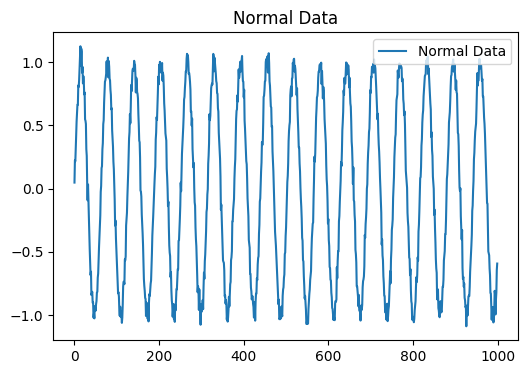

In [3]:
# 정상 데이터 생성
n_points = 1000
time = np.arange(0, n_points)
normal_data = np.sin(0.1 * time) + np.random.normal(0, 0.05, len(time))

# 정상 데이터 시각화
plt.figure(figsize=(6, 4))
plt.plot(normal_data, label='Normal Data')
plt.title("Normal Data")
plt.legend()
plt.show()

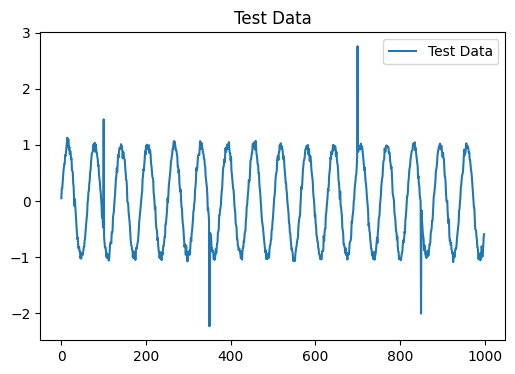

In [4]:
# 테스트 데이터 생성
test_data = normal_data.copy()

# 이상치 데이터는 특정 '지점'에서 비정상적인 값을 보이도록 생성
test_data[100] += 2.0
test_data[350] -= 1.8
test_data[700] += 2.0
test_data[850] -= 1.8

# 테스트 데이터 시각화
plt.figure(figsize=(6, 4))
plt.plot(test_data, label='Test Data')
plt.title("Test Data")
plt.legend()
plt.show()

## 데이터 전처리

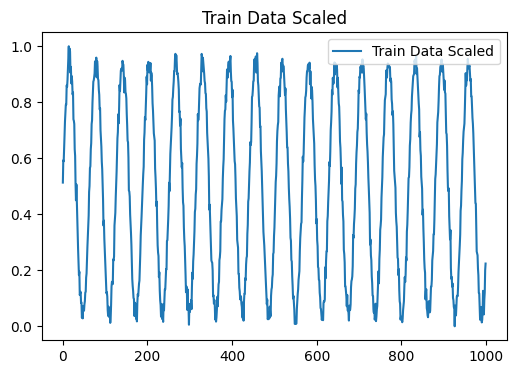

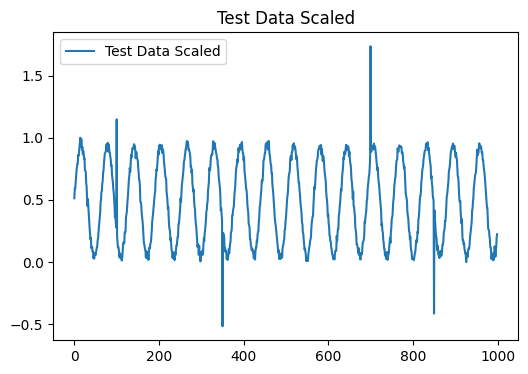

In [5]:
# 데이터 스케일링
scaler = MinMaxScaler()
train_data_scaled = scaler.fit_transform(normal_data.reshape(-1, 1))
test_data_scaled = scaler.transform(test_data.reshape(-1, 1))

plt.figure(figsize=(6, 4))
plt.plot(train_data_scaled, label='Train Data Scaled')
plt.title("Train Data Scaled")
plt.legend()
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(test_data_scaled, label='Test Data Scaled')
plt.title("Test Data Scaled")
plt.legend()
plt.show()

In [6]:
# 시계열 데이터를 시퀀스 데이터로 변환하는 함수
def create_sequences(data, seq_length):
    xs = []
    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length)]
        xs.append(x)
    return np.array(xs)

SEQ_LENGTH = 15 # 시퀀스 길이

# 시퀀스 데이터 생성
train_sequences = create_sequences(train_data_scaled, SEQ_LENGTH)
test_sequences = create_sequences(test_data_scaled, SEQ_LENGTH)

# PyTorch 텐서로 변환
train_tensor = torch.FloatTensor(train_sequences).to(device)
test_tensor = torch.FloatTensor(test_sequences).to(device)

print(f"Train tensor shape: {train_tensor.shape}") # (samples, seq_length, features)
print(f"Test tensor shape: {test_tensor.shape}")

Train tensor shape: torch.Size([985, 15, 1])
Test tensor shape: torch.Size([985, 15, 1])


## 모델 정의

In [7]:
class LSTMAutoencoder(nn.Module):
    def __init__(self, n_features, hidden_dim, seq_len):
        super(LSTMAutoencoder, self).__init__()
        self.seq_len = seq_len
        self.n_features = n_features
        self.hidden_dim = hidden_dim

        # 인코더: LSTM
        self.encoder = nn.LSTM(
            input_size=n_features,
            hidden_size=hidden_dim,
            num_layers=1,
            batch_first=True # (batch, seq, feature) 순서로 데이터 처리
        )
        # 디코더: LSTM
        self.decoder = nn.LSTM(
            input_size=hidden_dim,
            hidden_size=n_features,
            num_layers=1,
            batch_first=True
        )

    def forward(self, x):
        # 인코딩
        # LSTM의 출력은 (outputs, (hidden_state, cell_state))
        _, (hidden, _) = self.encoder(x)
        
        # 디코딩
        # 인코더의 최종 hidden_state를 디코더의 입력 시퀀스로 사용
        # (batch_size, hidden_dim) -> (batch_size, seq_len, hidden_dim)
        decoder_input = hidden.permute(1, 0, 2).repeat(1, self.seq_len, 1)
        reconstructed, _ = self.decoder(decoder_input)
        
        return reconstructed

In [8]:
# 모델 인스턴스 생성
model = LSTMAutoencoder(
    n_features=train_tensor.shape[2],
    hidden_dim=32,
    seq_len=SEQ_LENGTH
).to(device)

print(model)

LSTMAutoencoder(
  (encoder): LSTM(1, 32, batch_first=True)
  (decoder): LSTM(32, 1, batch_first=True)
)


## 모델 학습

In [9]:
# 손실 함수 및 옵티마이저 정의
criterion = nn.L1Loss() # MAE Loss
optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 50

# 학습 루프
model.train() # 모델을 학습 모드로 설정
for epoch in range(num_epochs):
    # 순전파
    outputs = model(train_tensor)
    loss = criterion(outputs, train_tensor) # 입력 자신을 복원하는 것이 목표

    # 역전파 및 가중치 업데이트
    optimizer.zero_grad() # 그래디언트 초기화
    loss.backward()       # 역전파
    optimizer.step()      # 가중치 업데이트

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}')

Epoch [10/50], Loss: 0.553626
Epoch [20/50], Loss: 0.373052
Epoch [30/50], Loss: 0.319441
Epoch [40/50], Loss: 0.285413
Epoch [50/50], Loss: 0.253728


## 이상치 탐지

In [10]:
# 모델을 평가 모드로 설정
model.eval()

# 임계값(Threshold) 설정
with torch.no_grad():
    # 학습 데이터에 대한 복원 오차 계산 (임계값 설정을 위해)
    reconstructed_train = model(train_tensor)
    train_error = torch.mean(torch.abs(train_tensor - reconstructed_train), dim=[1, 2]).cpu().numpy()
    print(f"train_error.shape: {train_error.shape}")

threshold = np.mean(train_error) + 3 * np.std(train_error)
print(f"이상치 탐지 임계값(Threshold): {threshold:.4f}")

train_error.shape: (985,)
이상치 탐지 임계값(Threshold): 0.4592


In [11]:
with torch.no_grad():
    # 테스트 데이터에 대한 복원 오차 계산
    reconstructed_test = model(test_tensor)
    test_error = torch.mean(torch.abs(test_tensor - reconstructed_test), dim=[1, 2]).cpu().numpy()
    print(f"test_error.shape: {test_error.shape}")

# 임계값을 초과하는 '시퀀스'의 인덱스 찾기
anomalous_seq_indices = np.where(test_error > threshold)[0]
print(f"anomalous_seq_indices: {anomalous_seq_indices}")
print(f"탐지된 이상 시퀀스 인덱스 개수: {len(anomalous_seq_indices)}")

test_error.shape: (985,)
anomalous_seq_indices: []
탐지된 이상 시퀀스 인덱스 개수: 0


## 결과 시각화

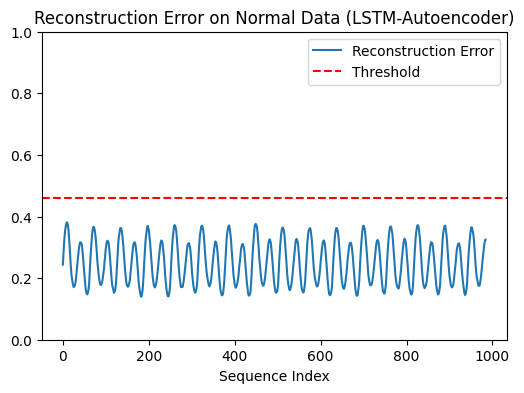

In [12]:
plt.figure(figsize=(6, 4))
plt.plot(train_error, label='Reconstruction Error')
plt.ylim(0.0, 1.0)
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.title("Reconstruction Error on Normal Data (LSTM-Autoencoder)")
plt.xlabel("Sequence Index")
plt.legend()
plt.show()

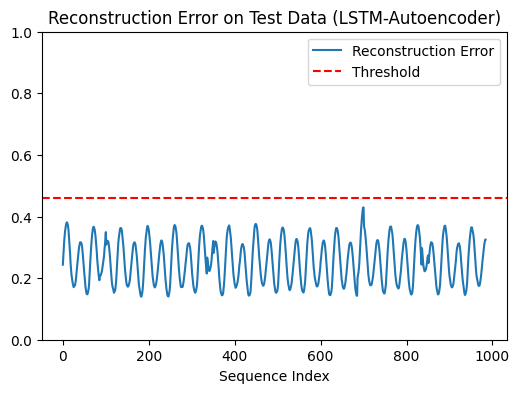

In [13]:
plt.figure(figsize=(6, 4))
plt.plot(test_error, label='Reconstruction Error')
plt.ylim(0.0, 1.0)
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.title("Reconstruction Error on Test Data (LSTM-Autoencoder)")
plt.xlabel("Sequence Index")
plt.legend()
plt.show()

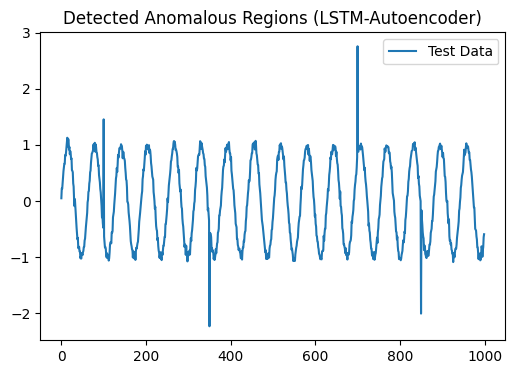

In [14]:
# 테스트 데이터와 탐지된 이상치 '구간' 함께 시각화
plt.figure(figsize=(6, 4))
plt.plot(test_data, label='Test Data')

# 이상치로 탐지된 각 시퀀스 구간을 음영으로 표시
for seq_idx in anomalous_seq_indices:
    # 해당 시퀀스가 시작하는 테스트 데이터의 인덱스
    start_idx = seq_idx
    end_idx = start_idx + SEQ_LENGTH
    plt.axvspan(start_idx, end_idx, color='red', alpha=0.08, label='_nolegend_')

plt.title("Detected Anomalous Regions (LSTM-Autoencoder)")
plt.legend()
plt.show()